# Practical session n°5

Notions:
- Quantile regression
- Pinball Loss


Duration: 1 h 30

In this practical, we immerse ourselves again in the context where the training inputs ($x$) and targets ($y$) are images of the same spatial dimensions. However, we assume that the dependence of $y$ on $x$ is probabilistic in nature. In other words, there exist conditional laws $p(y | x)$, and these laws need to be characterized.

Here, we limit ourselves to conditional marginals, meaning the laws $p(y_{i,j} | x)$ where $y_{i,j}$ represents the value of the target $y$ at the pixel $(i,j)$. To characterize these laws, several approaches are possible. For instance, one can attempt to estimate their quantiles or moments. The following exercises illustrate a method for estimating quantiles.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [2]:
! git clone https://github.com/0Yassine0/ML_S5_etudiants
import sys
sys.path.append('ML_S5_etudiants/practicals/P5')
from utils_P5 import gen_proba, voir_batch2D, UNet

Cloning into 'ML_S5_etudiants'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 200 (delta 43), reused 78 (delta 18), pack-reused 73 (from 1)
Receiving objects: 100% (200/200), 12.89 MiB | 16.07 MiB/s, done.
Resolving deltas: 100% (56/56), done.


**Exercise 1**: on the PINBALL loss

As seen in the previous practical session n°4, using the Mean Absolute Error (MAE) led the model to provide the conditional median, which is a particular quantile. To estimate other quantiles, it is sufficient to modify the MAE.

This is what we are going to do on a simple problem where the link between the input and the target is defined by:
$$y_{i,j} \sim \mathcal{N}(\mu(x_{i,j}), \sigma(x_{i,j})) $$
where $\mu$ and $\sigma$ are a priori unknown.

The gen_proba function from the utile.py module will allow us to "explore" our dataset, or in other words, to sample the random pair $(x, y)$.

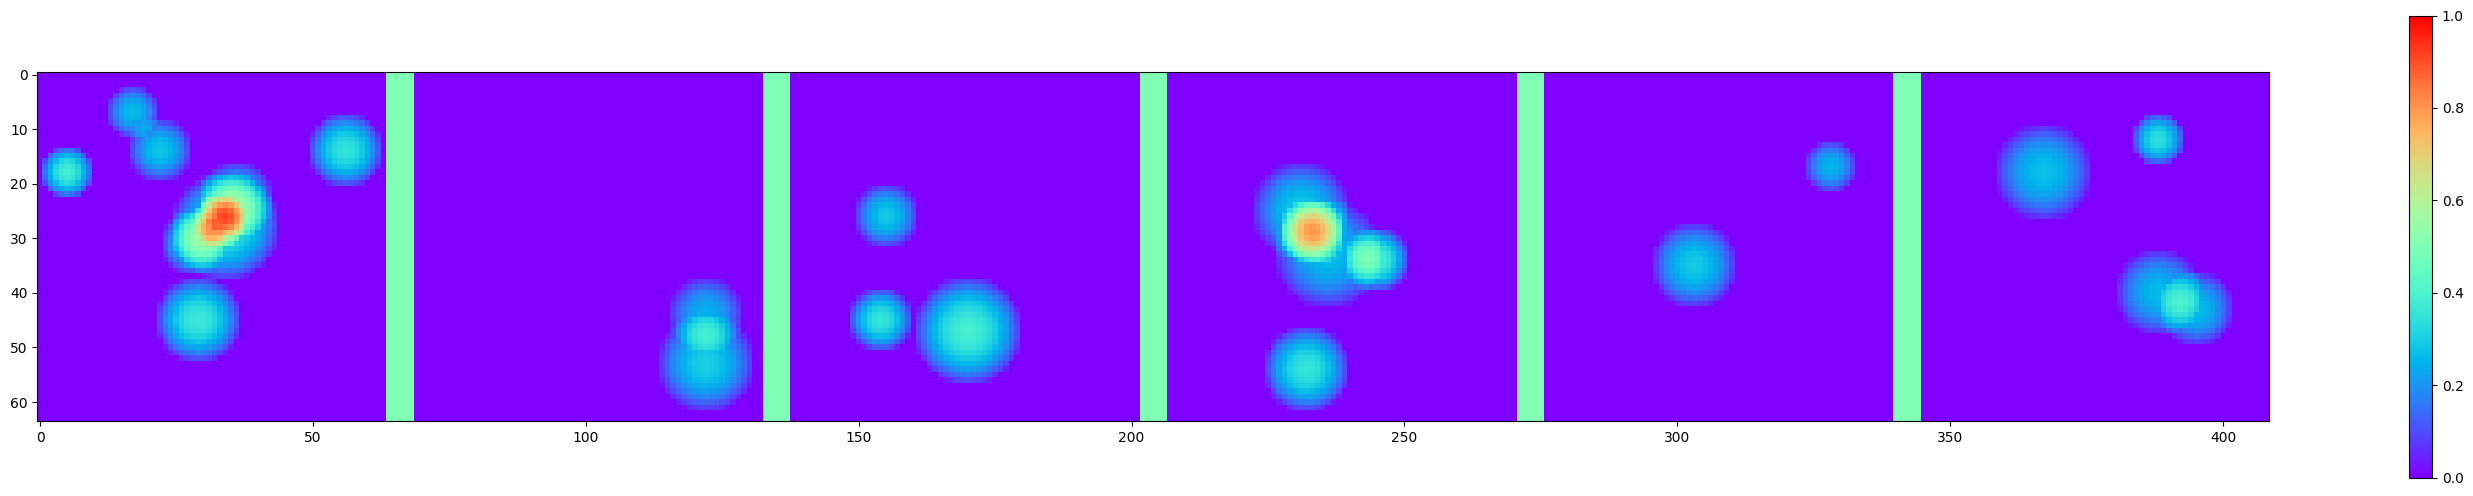

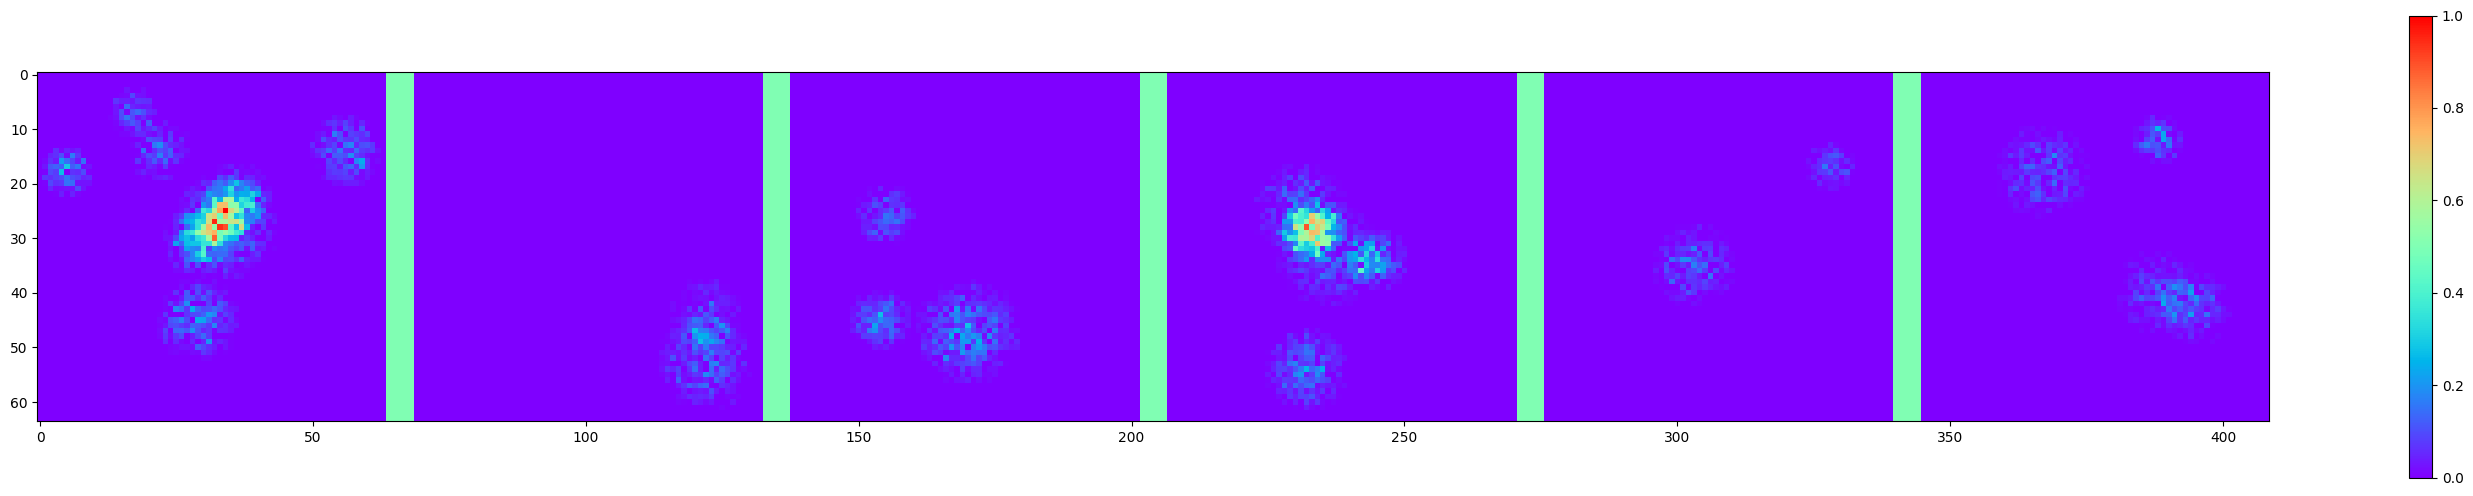

In [3]:
# sampling (x,y) :

input, target = gen_proba(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=1)

Let's consider the cost function be defined at the pixel level by:
$$\mathcal{L}_t(y,z) =  \rho_t(z - y) $$  
where:
$$\rho_t(u) = t \times max(u,0) + (t-1) \times min(u,0) $$

**Q1** Plot the graph of $\rho_t$ for different values of $t$ in the range [0, 1] using *matplotlib.pyplot*.
How does $\mathcal{L}_t$ generalize the MAE?

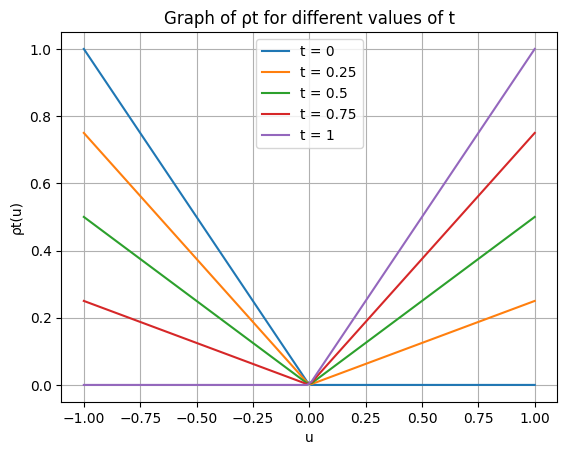

In [7]:
def rho_t(u, t):
    return t * np.maximum(u, 0) + (t - 1) * np.minimum(u, 0)

u_values = np.linspace(-1, 1, 100)

# Plotting for different values of t
for t in [0, 0.25, 0.5, 0.75, 1]:
    plt.plot(u_values, rho_t(u_values, t), label=f't = {t}')

plt.xlabel('u')
plt.ylabel('ρt(u)')
plt.title('Graph of ρt for different values of t')
plt.legend()
plt.grid(True)
plt.show()


**Q2** In the following cell, code a cost function adapted to the estimation of $t$-th quantiles (use *.clamp*( ))

In [32]:
def rho(u,t):
        loss = torch.mean(t * torch.clamp(u, min=0) + (t - 1) * torch.clamp(u, max=0))
        return loss

**Q3** Train a U-Net to estimate the ninth decile.

In [33]:
def criterion(output, target):
  return rho(target-output, 0.9)

In [34]:
fcn = UNet(1,1,8).cuda()
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [35]:
nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):

        input, target = gen_proba(batchsize)

        input = input.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = fcn(input)
        loss = criterion(output, target)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

Epoch 0
Epoch loss: 0.0135
Epoch 1
Epoch loss: 0.0038
Epoch 2
Epoch loss: 0.0030
Epoch 3
Epoch loss: 0.0028
Epoch 4
Epoch loss: 0.0027
Epoch 5
Epoch loss: 0.0028
Epoch 6
Epoch loss: 0.0028
Epoch 7
Epoch loss: 0.0024
Epoch 8
Epoch loss: 0.0027
Epoch 9
Epoch loss: 0.0025
Epoch 10
Epoch loss: 0.0026
Epoch 11
Epoch loss: 0.0023
Epoch 12
Epoch loss: 0.0021
Epoch 13
Epoch loss: 0.0023
Epoch 14
Epoch loss: 0.0022
Epoch 15
Epoch loss: 0.0021
Epoch 16
Epoch loss: 0.0023
Epoch 17
Epoch loss: 0.0021
Epoch 18
Epoch loss: 0.0022
Epoch 19
Epoch loss: 0.0019
Epoch 20
Epoch loss: 0.0019
Epoch 21
Epoch loss: 0.0024
Epoch 22
Epoch loss: 0.0021
Epoch 23
Epoch loss: 0.0021
Epoch 24
Epoch loss: 0.0020
Epoch 25
Epoch loss: 0.0018
Epoch 26
Epoch loss: 0.0021
Epoch 27
Epoch loss: 0.0019
Epoch 28
Epoch loss: 0.0021
Epoch 29
Epoch loss: 0.0019
Epoch 30
Epoch loss: 0.0019
Epoch 31
Epoch loss: 0.0022
Epoch 32
Epoch loss: 0.0019
Epoch 33
Epoch loss: 0.0019
Epoch 34
Epoch loss: 0.0019
Epoch 35
Epoch loss: 0.0019
Ep

**Q4** The ground truth is given by:
$$ \mu(x_{i,j}) = {x}_{i,j}^2 $$
and
$$ \sigma(x_{i,j}) = 0.2 \times x_{i,j} $$

Use [torch.distributions.normal.Normal](https://pytorch.org/docs/stable/distributions.html) to verify that the result corresponds well to the expected quantile.

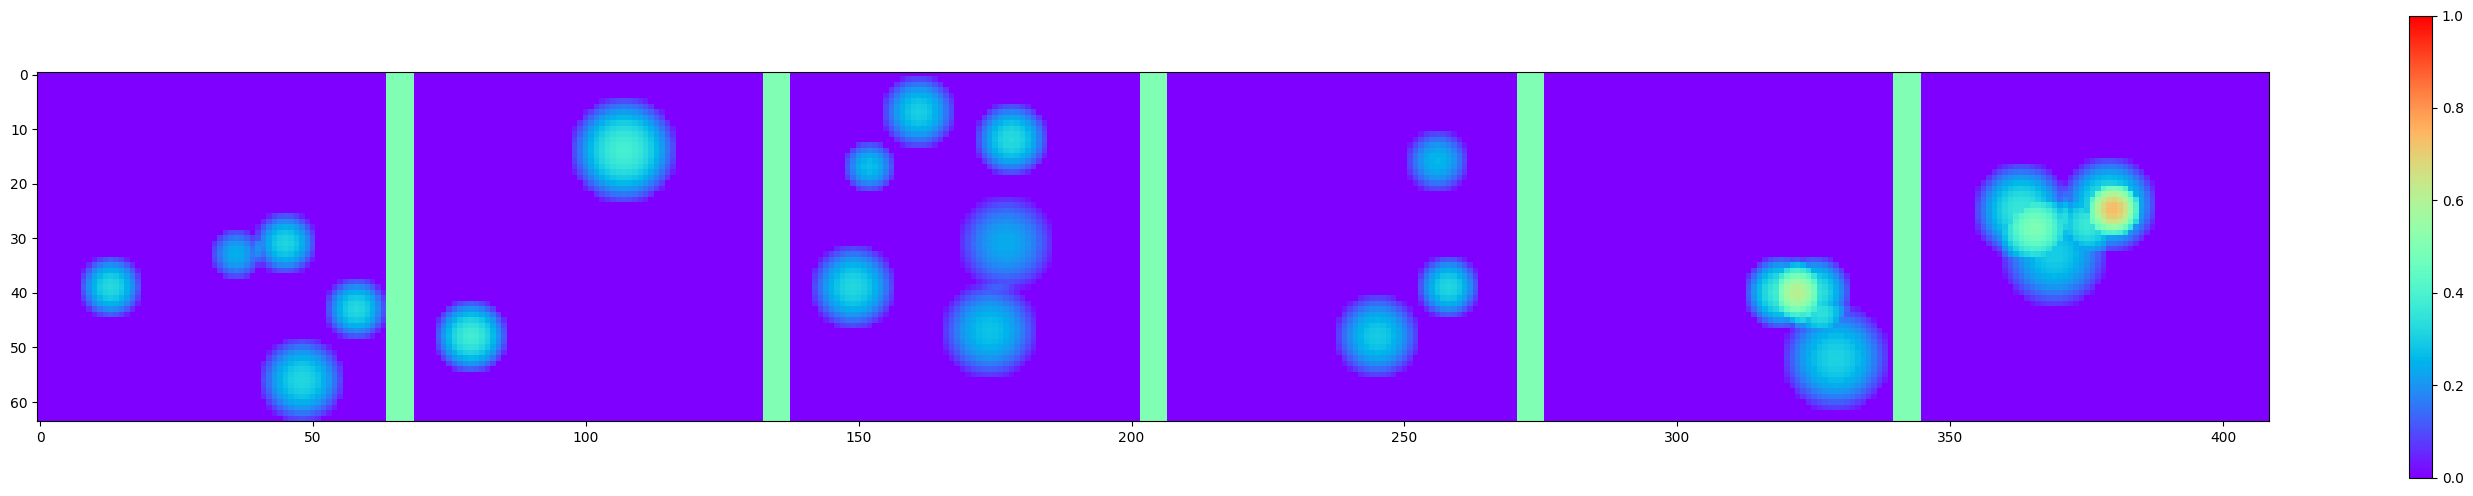

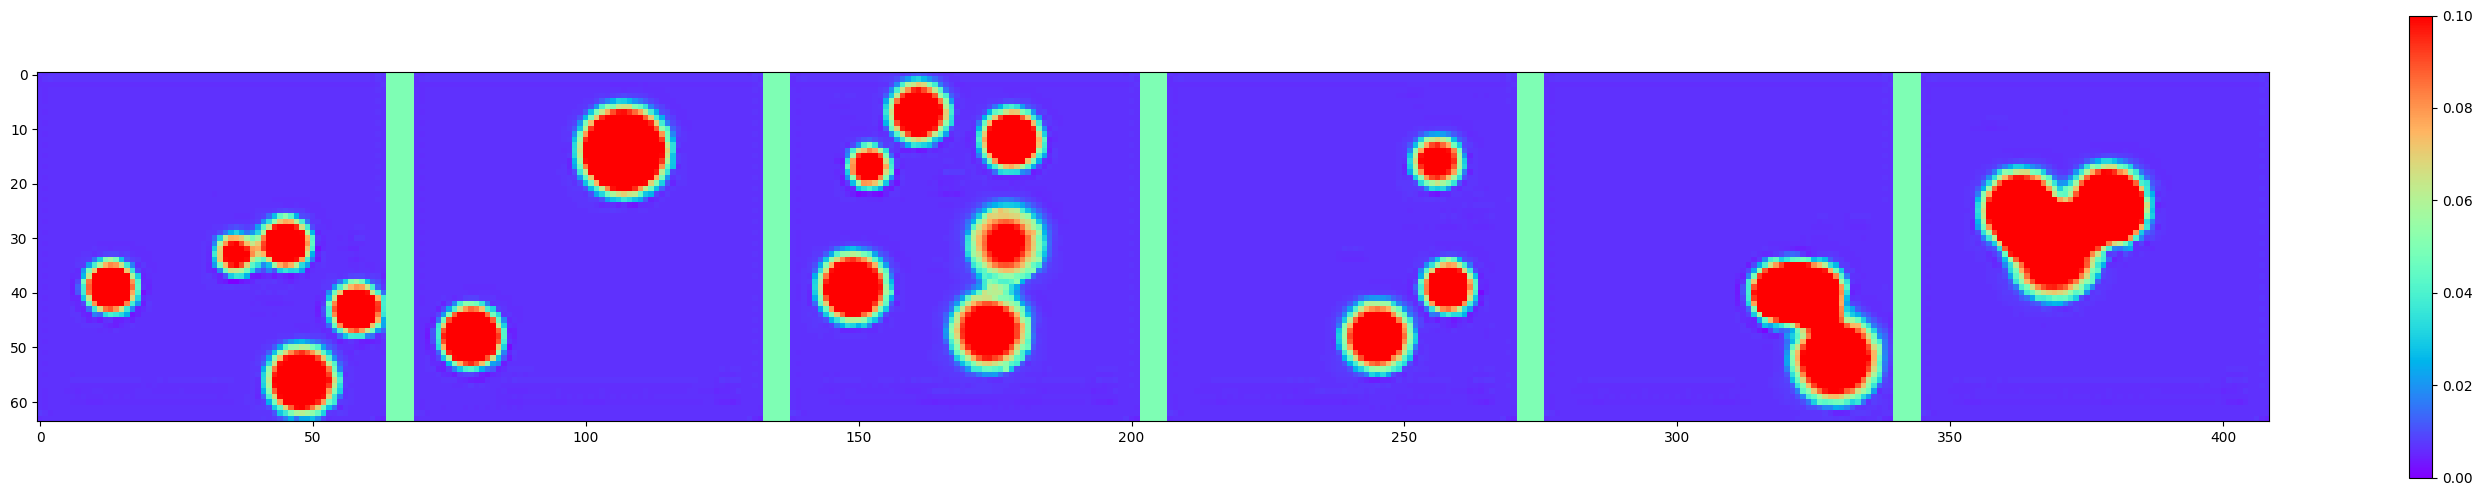

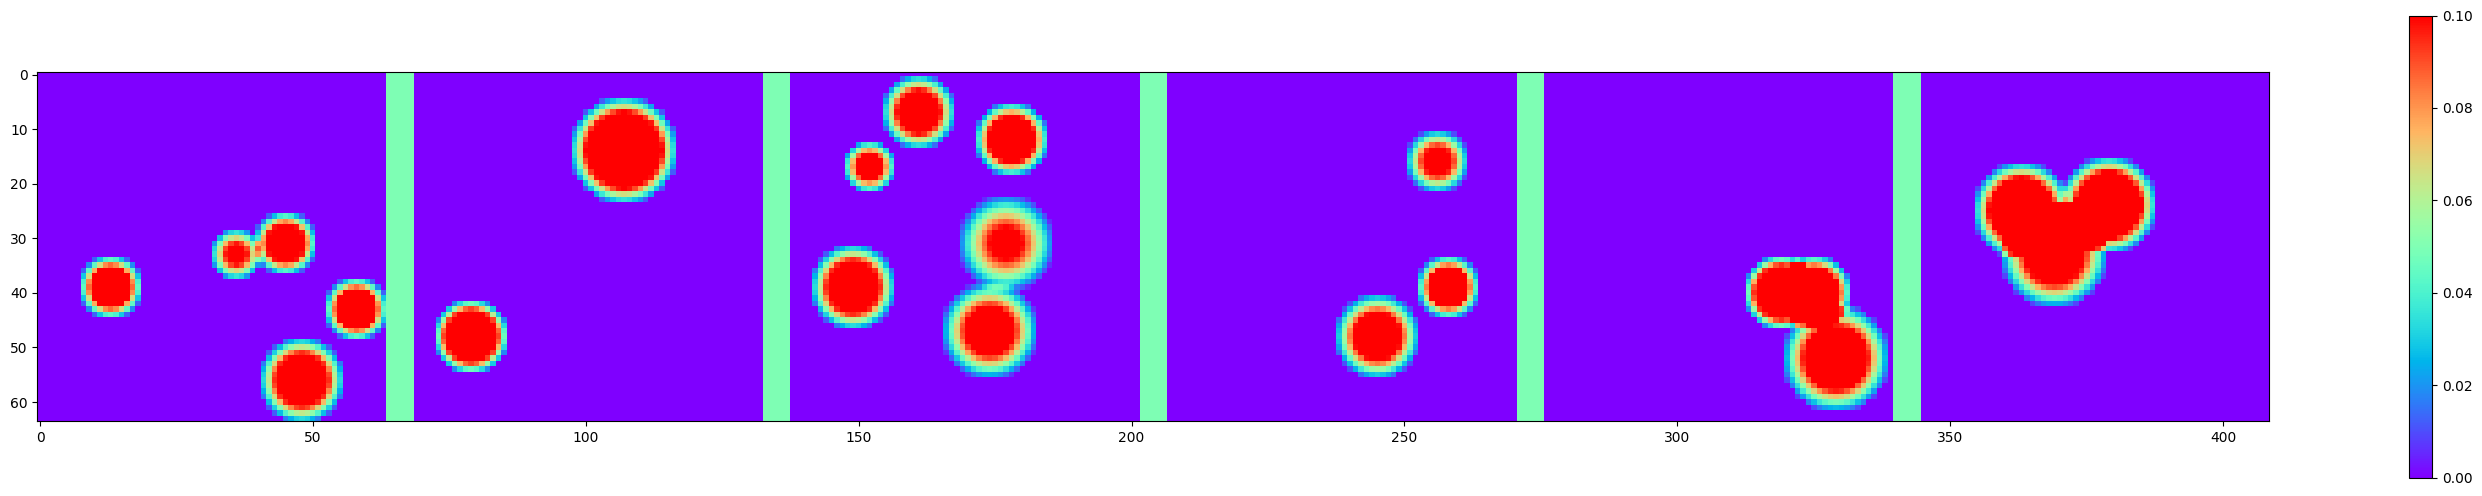

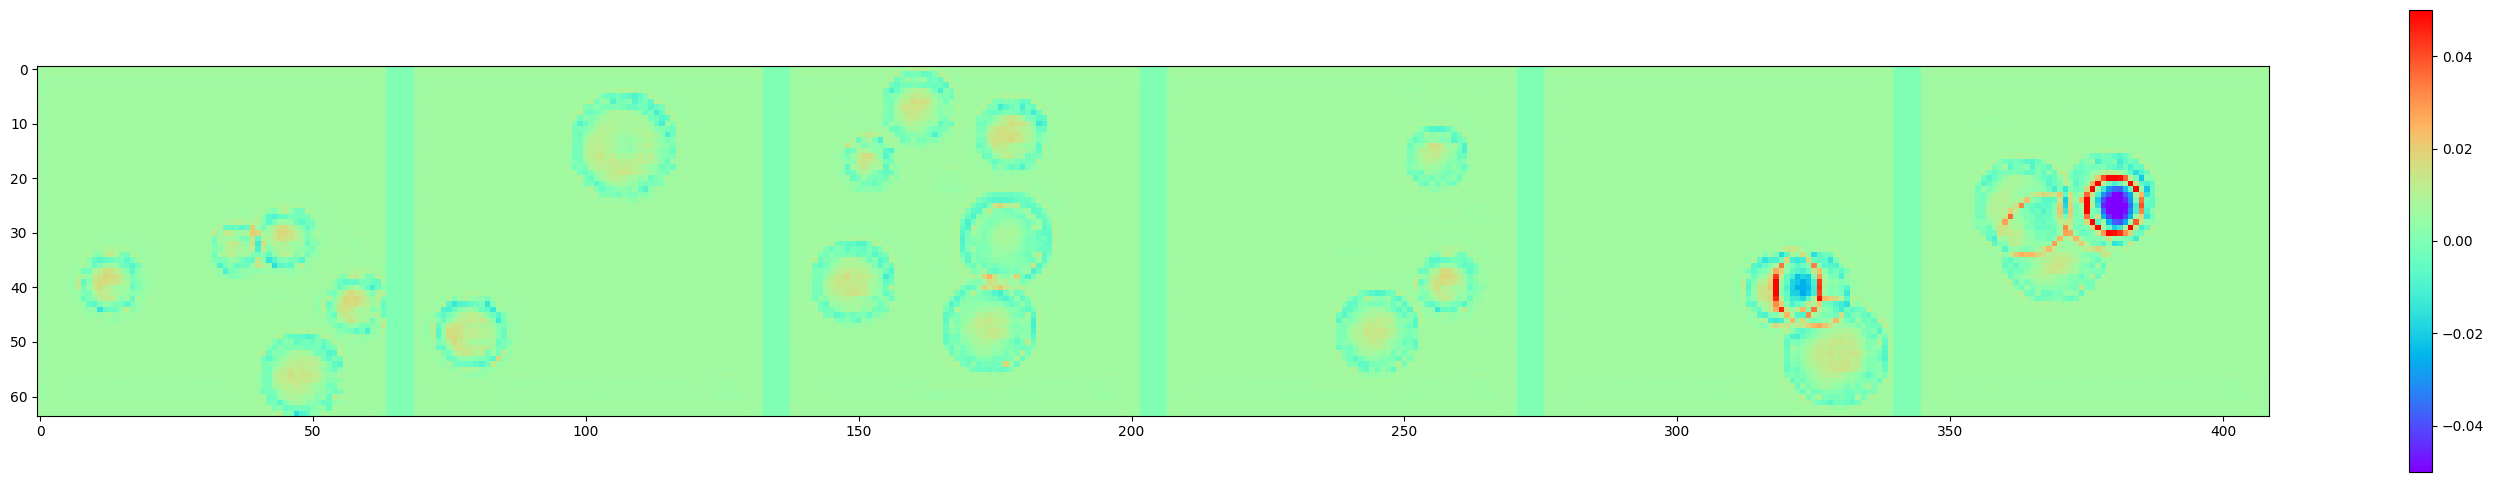

In [41]:
# viz:
fcn.eval()
input, target = gen_proba(6)
output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1) # inputs
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=0,max_scale=0.1) # outputs

# true quantile
mu = input**2
sigma = 0.2 * input + 1e-6
dist = torch.distributions.normal.Normal(mu, sigma)
true_quantiles = dist.icdf(torch.tensor([0.9]))

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(true_quantiles, 6, fig2, k=0, min_scale=0.,max_scale=0.1) # ninth decile
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output.detach().cpu() - true_quantiles, 6, fig2, k=0, min_scale=-0.05,max_scale=0.05) # outputs - ninth decile


**Exercise 2**: a trickier dependence

Let's now work with the following *gen_proba_2* function.

In [42]:
from utils_P5 import make_batch
def gen_proba_2(n):
  target1 = make_batch(n, rec = 0., noisy_rec= 0., disc = 0.0015)
  target2 = make_batch(n, rec = 0.001, noisy_rec= 0., disc = 0.)
  m = torch.normal(2, 2. + target2)
  input = target1 + target2
  target = m
  return  input, target


Here, the dependence of $y$ upon $x$ is not clearly visible in the input-target pairs:

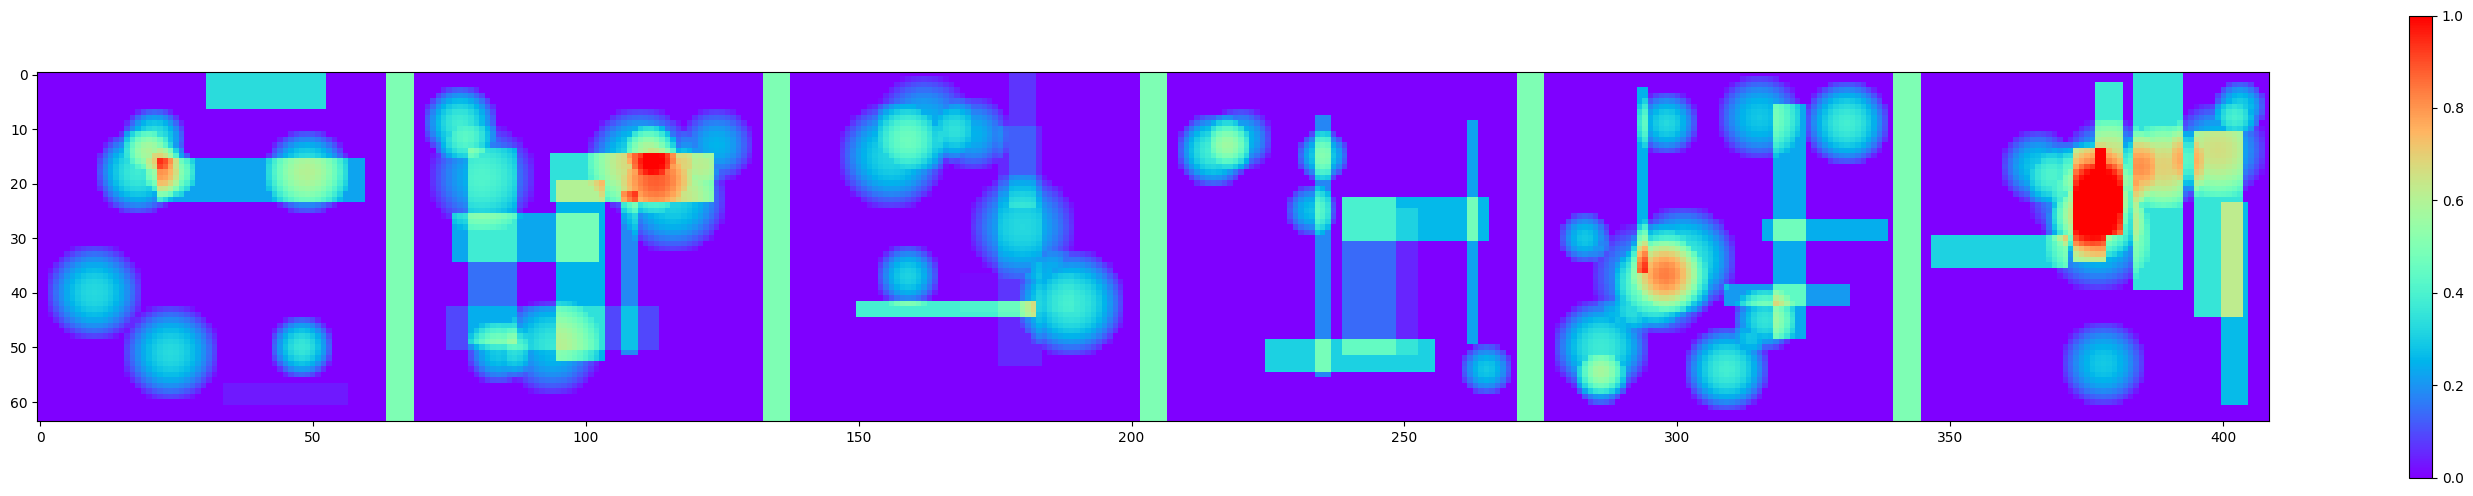

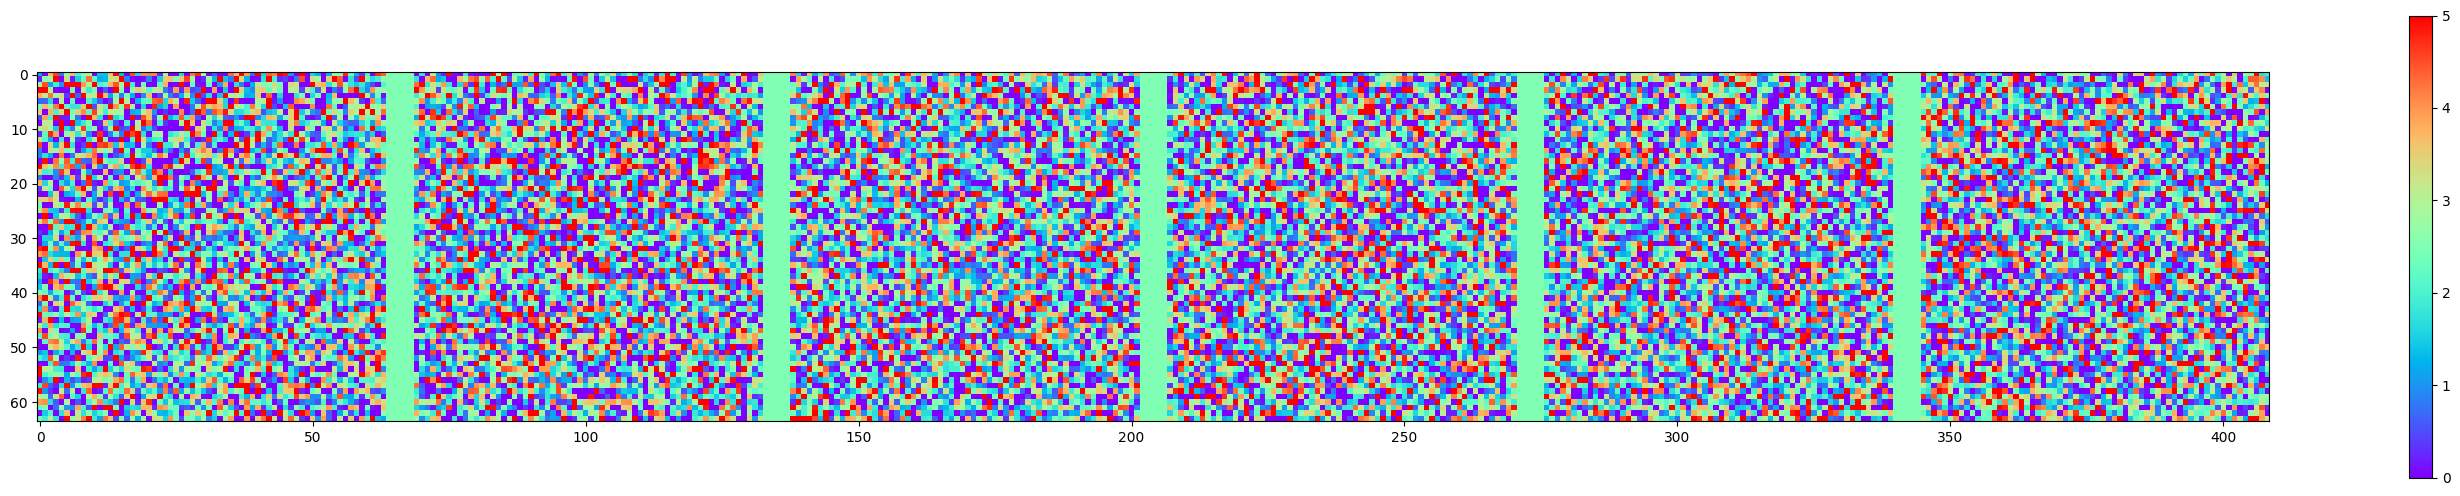

In [43]:
input, target = gen_proba_2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig1, k=0, min_scale=0,max_scale=5)

**Q1** Estimate the 0.1 quantiles of the marginal distributions and visualize the result.

In [ ]:
def criterion2(output, target):
  return rho(target-output, 0.1)  #on vise le premier décile

nepochs = 50
nbatches = 100
batchsize = 64

train_losses = []

for epoch in range(nepochs):
    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):

        input, target = gen_proba_2(batchsize)

        input = input.cuda()
        target = target.cuda()

        optimizer.zero_grad()
        output = fcn(input)
        loss = criterion2(output, target)
        epoch_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)

    print(f'Epoch loss: {epoch_loss:.4f}')

Epoch 0
Epoch loss: 0.3613
Epoch 1
Epoch loss: 0.3591
Epoch 2
Epoch loss: 0.3588
Epoch 3
Epoch loss: 0.3588
Epoch 4
Epoch loss: 0.3588
Epoch 5
Epoch loss: 0.3587
Epoch 6
Epoch loss: 0.3585
Epoch 7
Epoch loss: 0.3588
Epoch 8
Epoch loss: 0.3588
Epoch 9
Epoch loss: 0.3587
Epoch 10
Epoch loss: 0.3586
Epoch 11
Epoch loss: 0.3587
Epoch 12
Epoch loss: 0.3585
Epoch 13
Epoch loss: 0.3587
Epoch 14
Epoch loss: 0.3586
Epoch 15
Epoch loss: 0.3585
Epoch 16
Epoch loss: 0.3585
Epoch 17
Epoch loss: 0.3584
Epoch 18
Epoch loss: 0.3586
Epoch 19
Epoch loss: 0.3586
Epoch 20
Epoch loss: 0.3585
Epoch 21
Epoch loss: 0.3584
Epoch 22
Epoch loss: 0.3585
Epoch 23
Epoch loss: 0.3585
Epoch 24
Epoch loss: 0.3585
Epoch 25
Epoch loss: 0.3583
Epoch 26


In [ ]:
#visualisation:

fcn.eval()

input, target = gen_proba_2(6)
output = fcn(input.cuda())

fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(output.detach().cpu(), 6, fig1, k=0, min_scale=-1,max_scale=0)

# true quantile
mu = input**2
sigma = 0.2 * input + 1e-6
dist = torch.distributions.normal.Normal(mu, sigma)
true_quantiles = dist.icdf(torch.tensor([0.1]))

fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(true_quantiles, 6, fig2, k=0, min_scale=0.,max_scale=0.1) # ninth decile
fig3 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output.detach().cpu() - true_quantiles, 6, fig2, k=0, min_scale=-0.05,max_scale=0.05) # outputs - ninth decile



**Q2** Do outputs depend on inputs? Is it a pixel-wise dependence as in exercise 1? (i.e., does the distribution of $y_{i,j}$ depend only on $x_{i,j}$)



**Exercise 3**:

One can attempt to estimate $n$ quantiles simultaneously. To achieve this, the simplest way is to:

* change the number of output channels of the U-Net—e.g., 99 channels if you are estimating the $n = 100$ quantiles of orders 1%, 2%, ... 99%.
* define the overall cost function by summing individual cost functions for each of the channels.
The goal of this exercise is to code a matrix version of this overall cost function and illustrate the convergence of the learning process.


**Q1** Let $t$ be a vector of size $n-1$, and $M$ be a 4th-order tensor. Code the function: $$dot(t, M) = M^{\prime}$$ where: $$M^{\prime}_{b,i,j} = \underset{0<c<n}{\sum} t_c \times M_{b,c,i,j}$$.

This function will allow to apply $\rho_{t_c}$ (see **Exercise 1**) to each channel $c$ of the output $M$ (where $b$ represents the batch index and $i,j$ represent spatial dimensions).

In [ ]:
def dot(t, M):
	return ...

**Q2** Complete the class *QuantileLoss*:

In [ ]:
class QuantileLoss(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  # quantile orders

    def forward(self, output, target):
        bs, _, nx, ny = target.shape
        ...
        loss = torch.mean(loss_by_pix)

        return loss

**Q3** Start the training with *gen_proba* and $n=100$, then evaluate the estimation.